In this notebook I performed a preliminary exploration on the Alibaba dataset. In particular the dataset is https://github.com/alibaba/clusterdata/tree/master/cluster-trace-microservices-v2021 and I look at one part of the MSCallGraph table.

I found 7386 unique microservices IDs that I guess can be used as nodes.
6 different rpc types that I assume can be used as relations.
Around 5 million triples.
In the same table, there are other fields that have ids and I think they are not relevant as features. Instead, there is the timestamp of the call and the response time of the call.
It is possible to join the table with the other tables to obtain other ids (e.g. the container id), and some information on the CPU utilization, and memory utilization. From my understanding CPU and memory utilization are not related to the microservices but to the container. Moreover, they say that a microservice can have more than one container.
However, they claim to have 20000 different microservices so the number of ids that I found seems coherent for now.

When plotting the table I obtained a very big graph with a big connected component. I assume that this graph can be used for training time, and then samples of single traces can be used at test time.

I reconstructed a single trace tree by usin calls of the same trace id, moreover it seems that the right way of creating a triplet <head, rel, tail> is <dm, rpctype, um>.
I am able to reconstruct the trace by using all the entities. However, I am not able to plot all the relations, instead I plotted just one relation per pair of nodes. Moreover, in some cases (e.g. by using trace id 0b521cf115919237353493000e8a6c) I was not able to create a connected trace graph. However it may be caused by corrupted entries or missing entries in the table (since the table that I am using is just a sample of the entire table)


In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('MSCallGraph_0.csv')
tempdf = df

In [3]:
df

Unnamed: 0                         traceid  timestamp  \
0                 0  0b133c1915919238193454000e5d37     219678   
1                 1  0b133c1915919238193454000e5d37     219684   
2                 2  0b133c1915919238193454000e5d37     219684   
3                 3  0b133c1915919238193454000e5d37     219684   
4                 4  0b133c1915919238193454000e5d37     219684   
...             ...                             ...        ...   
6088841     6088841  0b52069415919238409694000ea18b     241025   
6088842     6088842  0b52069415919238409694000ea18b     241025   
6088843     6088843  0b52069415919238409694000ea18b     241024   
6088844     6088844  0b52069415919238409694000ea18b     241022   
6088845     6088845  0b52069415919237741588000ea044     174164   

                       rpcid  \
0             0.1.3.1.1.1.12   
1            0.1.3.1.1.14.19   
2            0.1.3.1.1.14.18   
3             0.1.3.1.1.14.4   
4            0.1.3.1.1.14.17   
...                      ...   
6088841   0.1.1.2.7.1.10.1.2   
6088842  0.1.1.2.7.1.4.3.3.3   
6088843  0.1.1.2.7.1.4.3.3.2   
6088844    0.1.1.2.7.1.18.12   
6088845              0.1.1.1   

                                                        um rpctype  \
0        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
1        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
2        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
3        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
4        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
...                                                    ...     ...   
6088841  75e56c8fbb9336eb4dd40f5f609d5344203d374d73fd0b...     rpc   
6088842  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...     rpc   
6088843  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...      mc   
6088844  175834ec8169f3bd8afd2382d063d7f4f6815d7c6c8839...    http   
6088845  95a6f7f8345e2eca31ee74ddc19d547e7fc0f5c8e65772...      mc   

                                                        dm  \
0        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...   
1        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...   
2        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...   
3        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...   
4        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...   
...                                                    ...   
6088841  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...   
6088842  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...   
6088843  4bba5c2371c3384862e69615979c2aa5b7f1b4fc3ea914...   
6088844  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...   
6088845  9653f5baba69c9fb50bfb30a8571eb04dbceaae7c7f379...   

                                                 interface  rt  
0                                                      NaN   0  
1                                                      NaN   1  
2                                                      NaN   1  
3                                                      NaN   1  
4                                                      NaN   1  
...                                                    ...  ..  
6088841  7f2e118b0388e346c3062dd70a26228c63ca349cfdb1b9...   1  
6088842  603397982129ca7e0132392729db95219f557e3ad46d68...   1  
6088843                                                NaN   1  
6088844  14e30cd163c732912e048c4c837e15c4e90c062ebb795a...  18  
6088845                                                NaN   0  

[6088846 rows x 9 columns]

In [4]:
df.nunique()

Unnamed: 0    6088846
traceid        130512
timestamp      299889
rpcid          730721
um               1484
rpctype             6
dm               7362
interface        5894
rt               2991
dtype: int64

In [5]:
df.isna().sum()

Unnamed: 0          0
traceid             0
timestamp           0
rpcid               0
um              70248
rpctype             0
dm                  0
interface     3289128
rt                  0
dtype: int64

In [6]:
df = df.replace('(?)', np.NaN)
df.isna().sum()

Unnamed: 0          0
traceid             0
timestamp           0
rpcid               0
um             400034
rpctype             0
dm             445381
interface     3289128
rt                  0
dtype: int64

In [7]:
df = df.replace('', np.NaN)
df.isna().sum()

Unnamed: 0          0
traceid             0
timestamp           0
rpcid               0
um             400034
rpctype             0
dm             445381
interface     3289128
rt                  0
dtype: int64

In [8]:
df = df.replace('NAN', np.NaN)
df.isna().sum()

Unnamed: 0          0
traceid             0
timestamp           0
rpcid               0
um             400034
rpctype             0
dm             445381
interface     3289128
rt                  0
dtype: int64

In [9]:
df=df.drop(['Unnamed: 0','traceid','timestamp','rpcid','interface','rt',],axis=1)

In [10]:
df

um rpctype  \
0        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
1        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
2        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
3        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
4        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
...                                                    ...     ...   
6088841  75e56c8fbb9336eb4dd40f5f609d5344203d374d73fd0b...     rpc   
6088842  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...     rpc   
6088843  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...      mc   
6088844  175834ec8169f3bd8afd2382d063d7f4f6815d7c6c8839...    http   
6088845  95a6f7f8345e2eca31ee74ddc19d547e7fc0f5c8e65772...      mc   

                                                        dm  
0        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
1        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
2        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
3        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
4        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
...                                                    ...  
6088841  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...  
6088842  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...  
6088843  4bba5c2371c3384862e69615979c2aa5b7f1b4fc3ea914...  
6088844  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...  
6088845  9653f5baba69c9fb50bfb30a8571eb04dbceaae7c7f379...  

[6088846 rows x 3 columns]

In [11]:
df = df.dropna()
df.isna().sum()

um         0
rpctype    0
dm         0
dtype: int64

In [12]:
df

um rpctype  \
0        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
1        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
2        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
3        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
4        5cca70246befb1f4c9546d2912b9419dee54439218efa5...      mc   
...                                                    ...     ...   
6088841  75e56c8fbb9336eb4dd40f5f609d5344203d374d73fd0b...     rpc   
6088842  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...     rpc   
6088843  614c66b178d3cfe299b11254ecb4321f85beca4b2ccac8...      mc   
6088844  175834ec8169f3bd8afd2382d063d7f4f6815d7c6c8839...    http   
6088845  95a6f7f8345e2eca31ee74ddc19d547e7fc0f5c8e65772...      mc   

                                                        dm  
0        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
1        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
2        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
3        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
4        b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...  
...                                                    ...  
6088841  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...  
6088842  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...  
6088843  4bba5c2371c3384862e69615979c2aa5b7f1b4fc3ea914...  
6088844  9a9e8613b6d7d1b573ba38dba19eec9c3cc460ab00cb49...  
6088845  9653f5baba69c9fb50bfb30a8571eb04dbceaae7c7f379...  

[5282260 rows x 3 columns]

In [13]:
df.nunique()

um         1474
rpctype       6
dm         7326
dtype: int64

In [14]:
triplets = []
entities = set()
relations = set()
for i in range(len(df)):
    head = df.iloc[i]['dm']
    tail = df.iloc[i]['um']
    rel = df.iloc[i]['rpctype']
    entities.add(head)
    entities.add(tail)
    relations.add(rel)
    triplets.append([head,rel,tail])

In [15]:
print(len(entities))
print(entities)

7386
{'6fbcbf605f7ae59d3c7efd909466c05f0fb2388c14e109ef4cba9707154f515b', '7408265599b65def10f7fff8020f6938c5f70c8482426e2ec70e8e7f06ef17ec', 'd9332c919a0ad2397d68fc28b8c3726405268655aa44b06b9166b11757b34e68', '0b81fcfb52f2ca990dc7c003a39ff122a03cf1d21b3160defe826827f5f056df', '802fcbce744357c65e012c40c4d7f46c51d33273c243eb3f7989cec6384ec4aa', 'da65d8ce314755e242a9f4067e4943e1d0d0993642b33be40a7349fe10e21525', 'f011761c1d8c02b9022ad0ab8516aff01fcf780a99f68ad2411bc02b85887458', 'eaba403620cbaae48747ee01c1f84900cff9874e9cf732ee5ee04f7d8df91219', 'e1b0f4724707edd086c7122057ad1ef5865d6f297b56bd8fdba4280566c69f54', '1f8090eee9581aaeecee4b98a7cb3be4b5ec19603ed87e1dd752c5c00f6d1ec5', '2ff4545031160759341aa1b009c2d5afe482e42cedcd404402aa3ff7cc58cb9f', 'fe37080ace22228ade9a2a5aa42b6130f53b2160f424795f798a8d0963d1b56f', 'f7a97c3d2d8b6ad617e0a79d52169769df71de6eb0363926f8561c8fe090a913', '3811d28e8288bc68c698d50333c4ad0ab54d329f3bc84b94d130ef92f0b49590', 'a7cc0150e742148626adde673a14157e5bbda6d74

In [16]:
print(len(relations))
print(relations)

6
{'http', 'userDefined', 'rpc', 'mc', 'mq', 'db'}


In [17]:
triplets

[['b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a2214208b9697238c1b11',
  'mc',
  '5cca70246befb1f4c9546d2912b9419dee54439218efa55a7a2e0e26e86ad749'],
 ['b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a2214208b9697238c1b11',
  'mc',
  '5cca70246befb1f4c9546d2912b9419dee54439218efa55a7a2e0e26e86ad749'],
 ['b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a2214208b9697238c1b11',
  'mc',
  '5cca70246befb1f4c9546d2912b9419dee54439218efa55a7a2e0e26e86ad749'],
 ['b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a2214208b9697238c1b11',
  'mc',
  '5cca70246befb1f4c9546d2912b9419dee54439218efa55a7a2e0e26e86ad749'],
 ['b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a2214208b9697238c1b11',
  'mc',
  '5cca70246befb1f4c9546d2912b9419dee54439218efa55a7a2e0e26e86ad749'],
 ['b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a2214208b9697238c1b11',
  'mc',
  '5cca70246befb1f4c9546d2912b9419dee54439218efa55a7a2e0e26e86ad749'],
 ['b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a2214208b9697238c1b11',
  'mc',
  '5cca70246befb1f4c9546d291

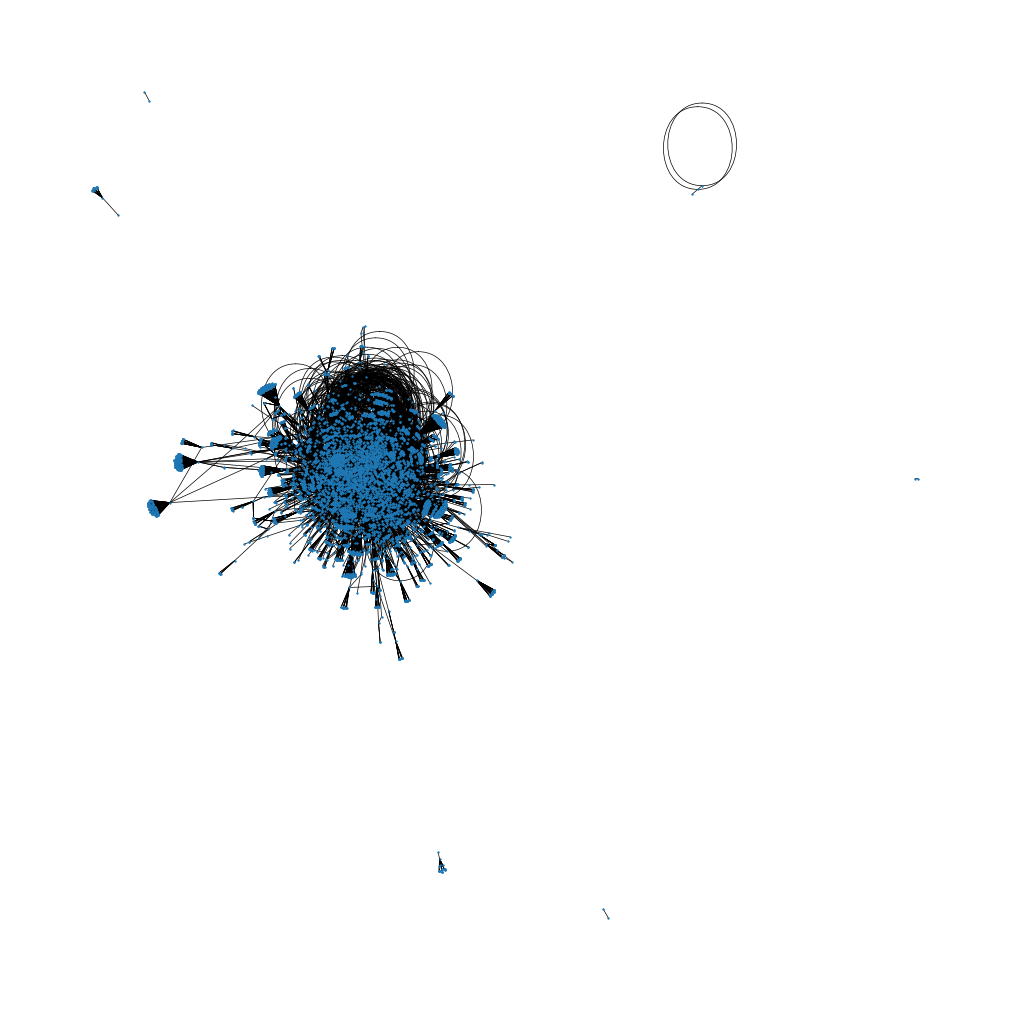

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph object
G = nx.Graph()

for entity in entities:
    G.add_node(entity)
for triplet in triplets:
    G.add_edge(triplet[0], triplet[2], label=triplet[1])

fig = plt.figure(1, figsize=(20, 20), dpi=50)

# Use NetworkX's built-in drawing function to visualize the graph
nx.draw(G, node_size = 5)

# Import matplotlib library to show the graph
plt.show()

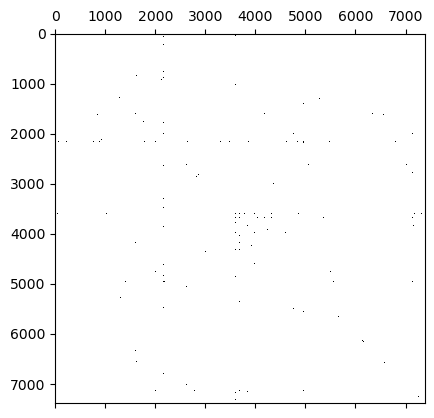

In [19]:
A = nx.to_numpy_matrix(G) #compute the adjacency matrix
plt.spy(A)

In [20]:
nx.is_connected(G)

False

In [21]:
nx.number_connected_components(G)

7

In [22]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

In [23]:
for subgraph in S:
    print(subgraph.size())

15869
17
1
19
1
4
1


In [24]:
giant_component = S[0]
giant_component.size()

15869

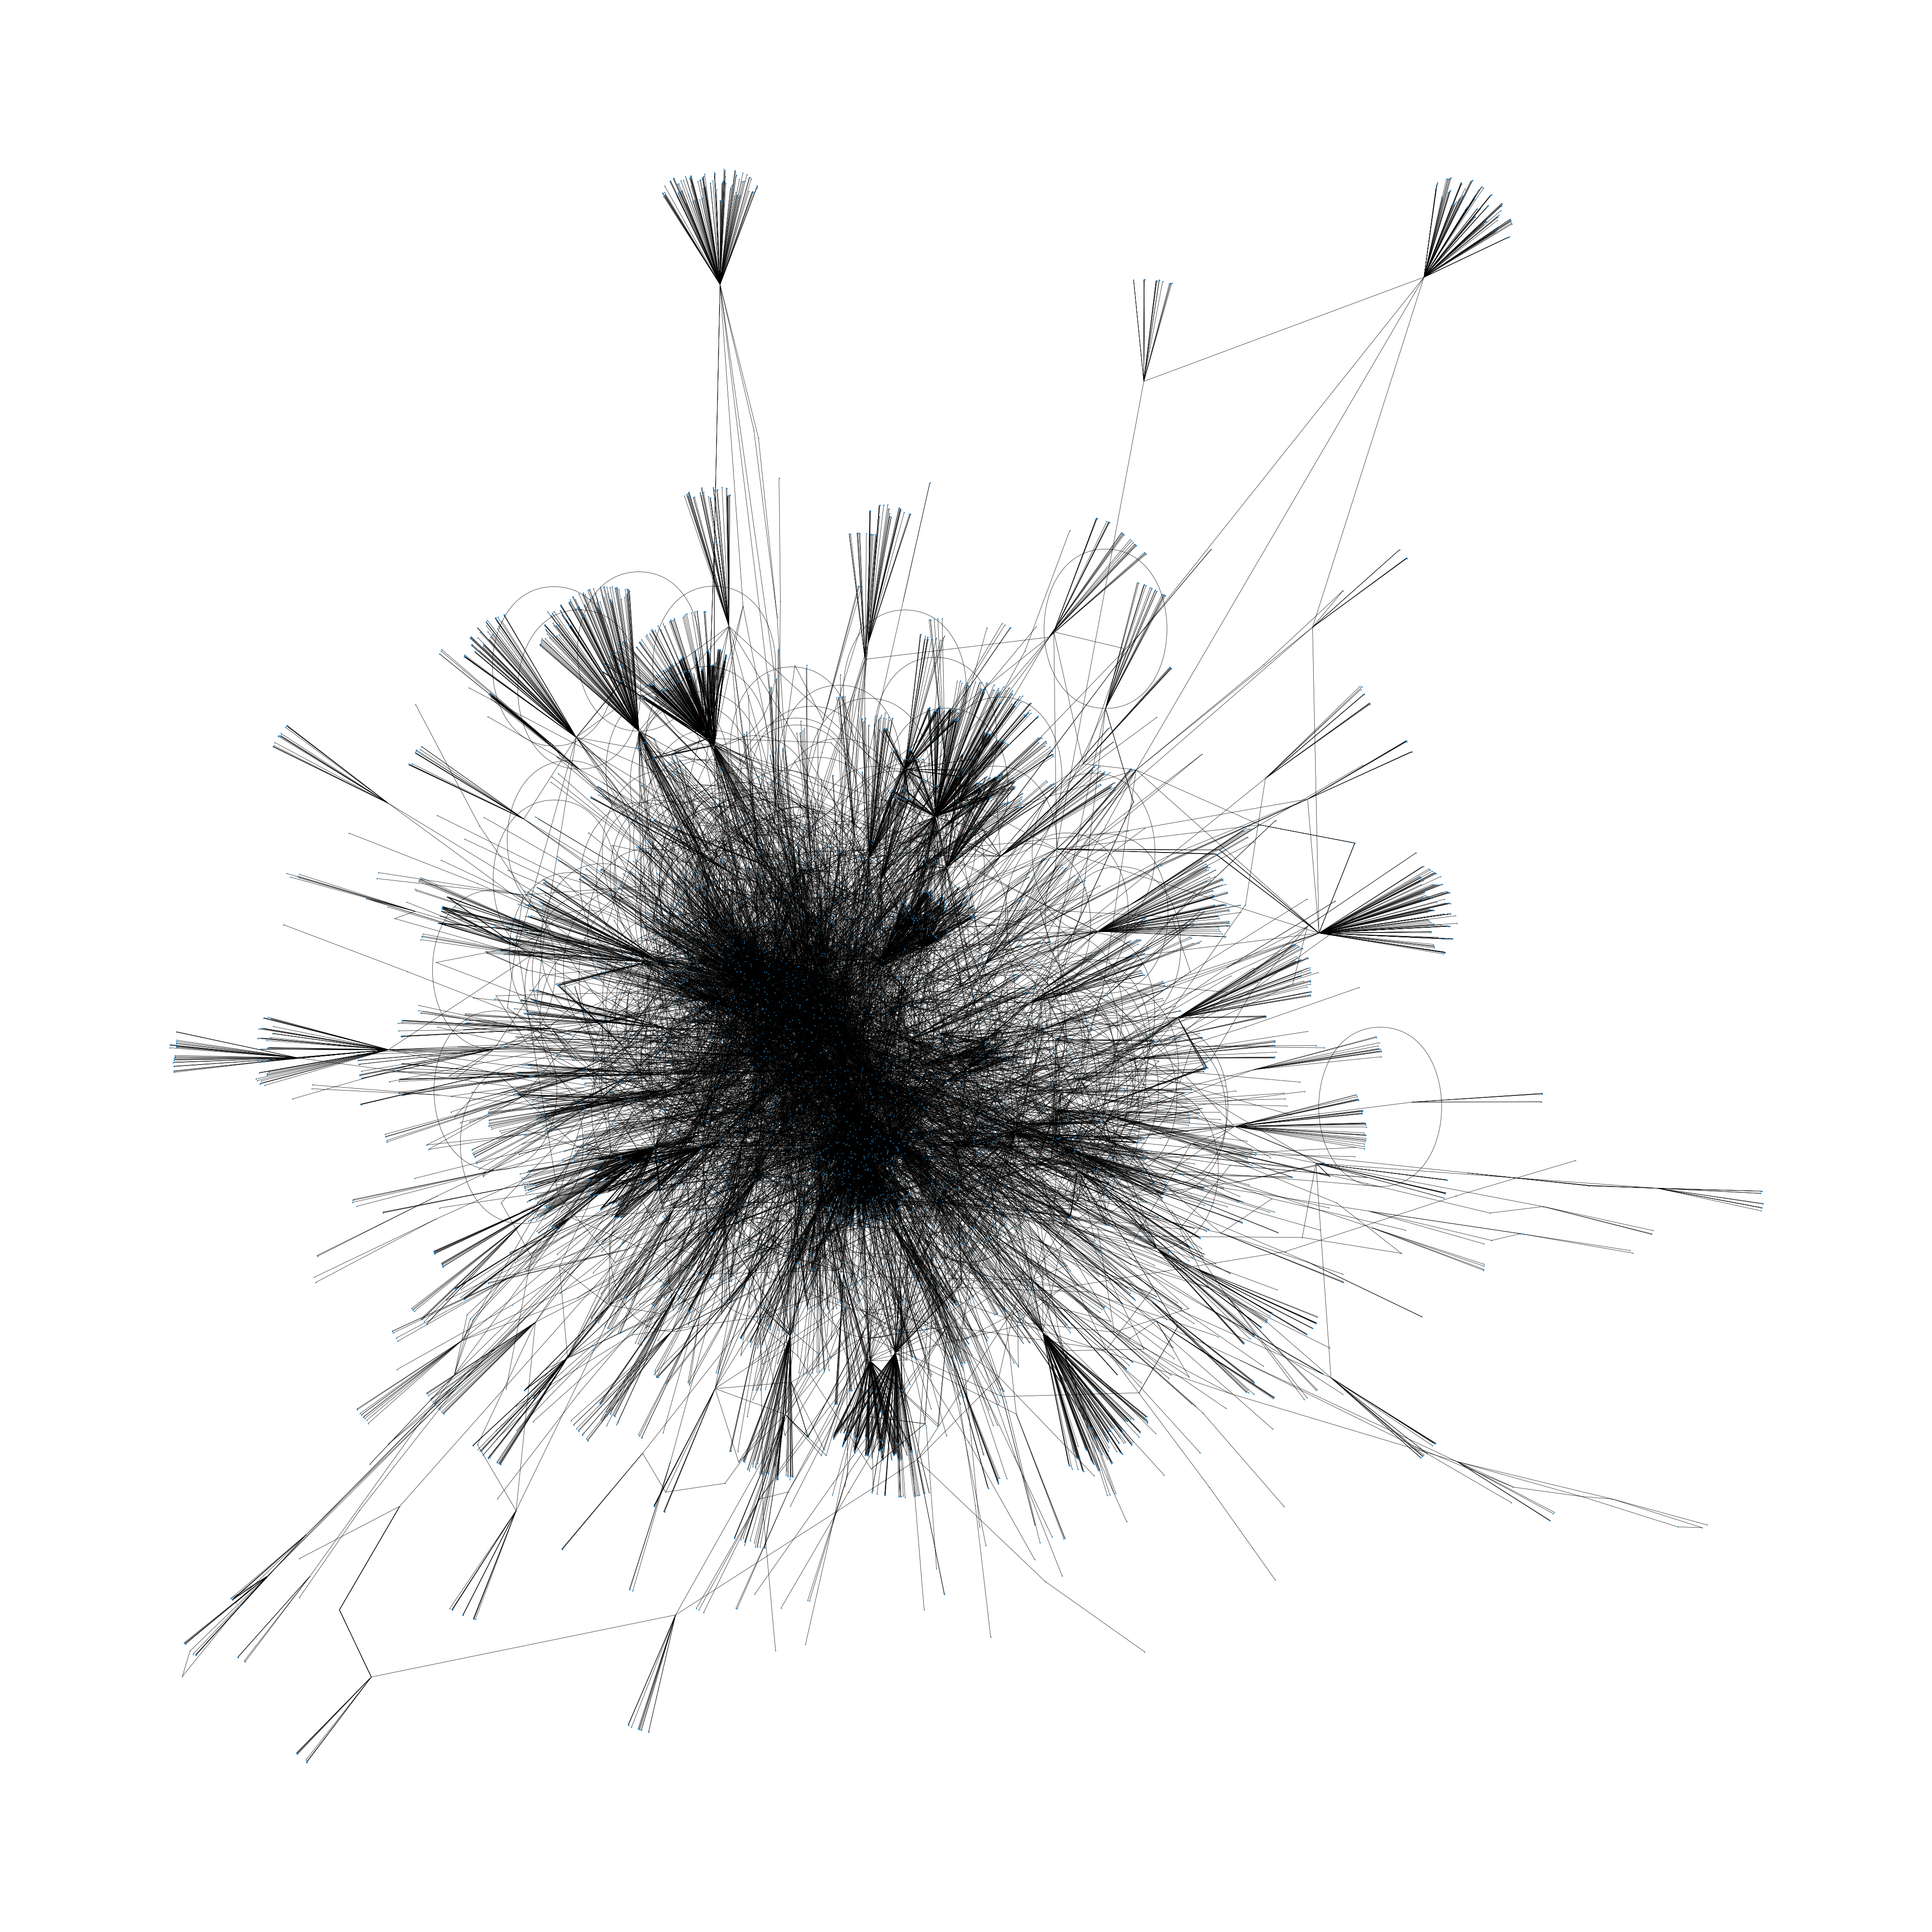

In [25]:
G = giant_component
fig = plt.figure(1, figsize=(80, 80), dpi=50)

# Use NetworkX's built-in drawing function to visualize the graph
nx.draw(G, node_size = 5)

# Import matplotlib library to show the graph
plt.show()

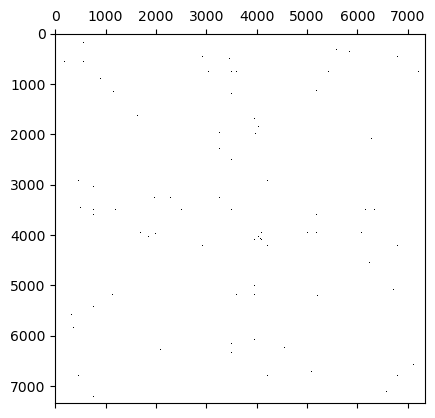

In [26]:
A = nx.to_numpy_matrix(G) #compute the adjacency matrix
plt.spy(A)

In [27]:
def draw_tree_graph_hierarchical(triplets,root):
    print("total triplets: ",len(triplets))
    inserted_triplets = set()
    from anytree import Node, RenderTree
    treeDict = {}
    rootNode = Node(root)
    treeDict[root] = rootNode

    i = 0
    while len(triplets)>0 and i<len(triplets):
        try:
            tempNode = treeDict[triplets[i][2]]
            newNode = Node(triplets[i][0],parent = tempNode)
            treeDict[triplets[i][0]] = newNode
            removed_elem = tuple(triplets.pop(i))
            inserted_triplets.add(removed_elem)
            i = 0
        except:
            i +=1
    print("Left elements: ", len(triplets))
    from anytree.exporter import DotExporter
#     for pre, fill, node in RenderTree(rootNode):
#         print("%s%s" % (pre, node.name))
    from anytree import LevelOrderGroupIter
    level_list = [[node.name for node in children] for children in LevelOrderGroupIter(rootNode, stop=lambda n: n == None)]
#     print(level_list)
    import networkx as nx
    import matplotlib.pyplot as plt

    # Create a graph object
    G = nx.Graph()
    for i in range(len(level_list)):
        for j in range(len(level_list[i])):
            G.add_node(level_list[i][j],layer = i)

    for triplet in inserted_triplets:
        G.add_edge(triplet[0], triplet[2], label=triplet[1])

    node_size = 30
    # Use NetworkX's built-in drawing function to visualize the graph
    # nx.draw(G)
    pos = nx.multipartite_layout(G,subset_key="layer")
    nx.draw_networkx_edges(G,pos,arrowstyle="-|>",arrowsize=10,width=1,arrows=True,node_size=node_size)
    nx.draw_networkx_nodes(G,pos,node_size = node_size)

    # Import matplotlib library to show the graph
    plt.show()

total triplets:  1
Left elements:  1


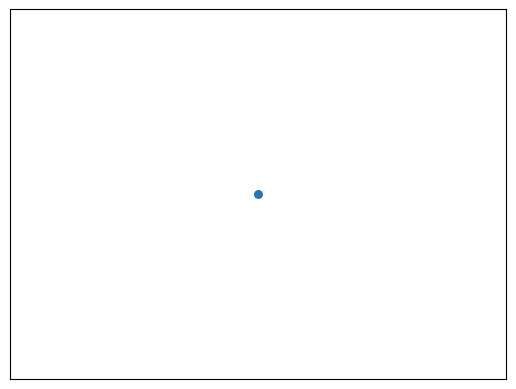

total triplets:  10
Left elements:  0


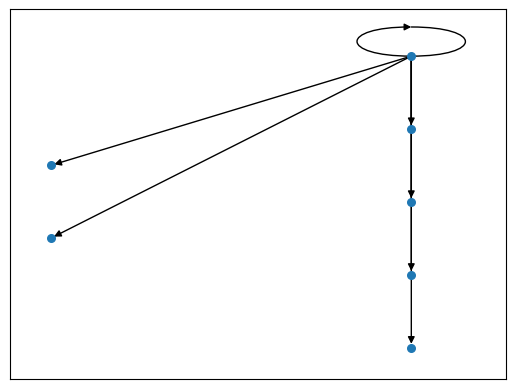

total triplets:  35
Left elements:  2


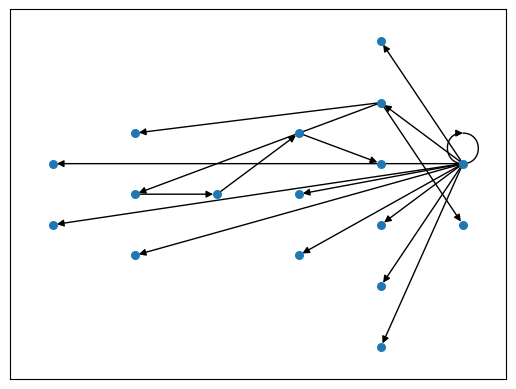

total triplets:  7
Left elements:  0


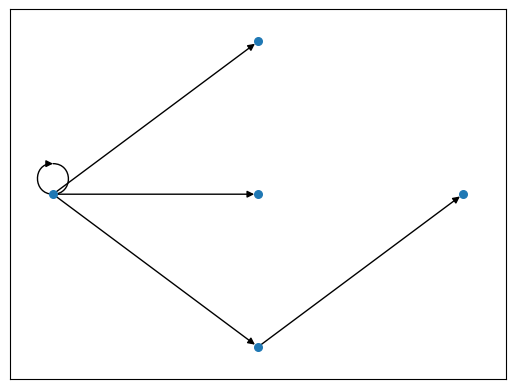

total triplets:  2
Left elements:  0


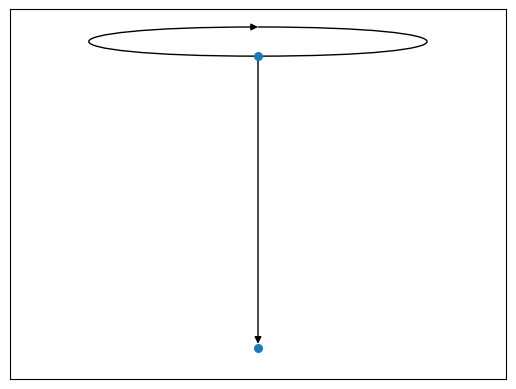

total triplets:  4
Left elements:  0


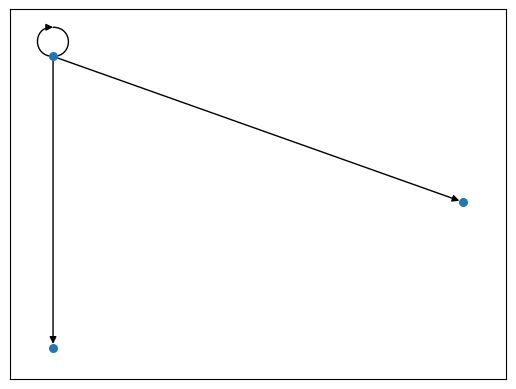

total triplets:  117
Left elements:  0


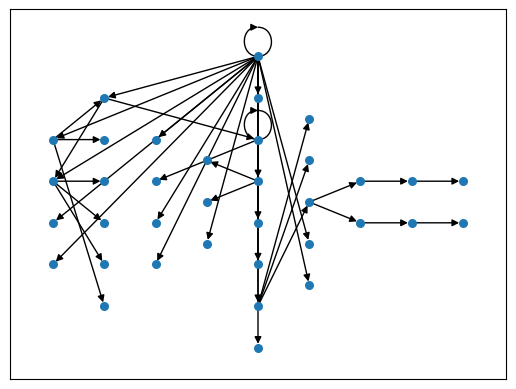

total triplets:  7
Left elements:  0


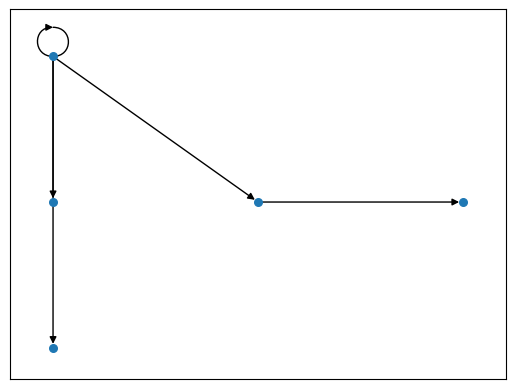

total triplets:  53
Left elements:  52


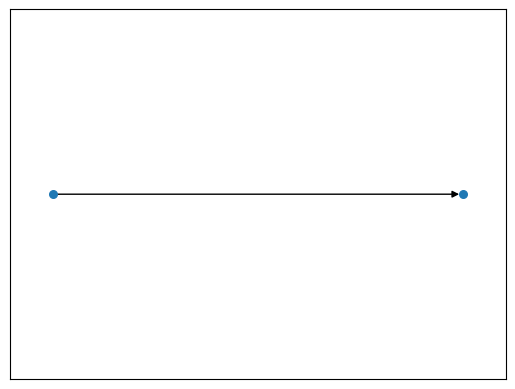

total triplets:  90
Left elements:  29


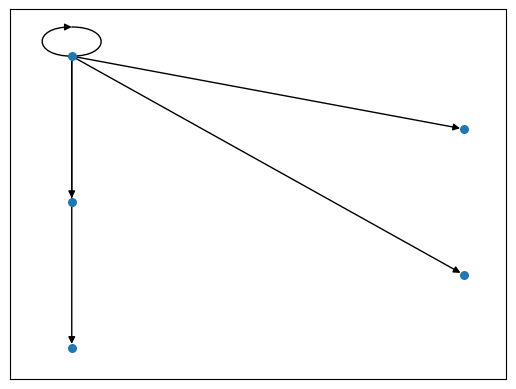

In [28]:
df = tempdf
df=df.drop(['Unnamed: 0','timestamp','rpcid','interface','rt',],axis=1)
df = df.replace('(?)', np.NaN)
df = df.replace('', np.NaN)
df = df.replace('NAN', np.NaN)
df = df.dropna()
traces = list(set(df['traceid']))
for i in range(10):
    df2 = df[df['traceid'] == traces[i]]
    triplets = []
    entities = set()
    relations = set()
    for i in range(len(df2)):
        head = df2.iloc[i]['dm']
        tail = df2.iloc[i]['um']
        rel = df2.iloc[i]['rpctype']
        entities.add(head)
        entities.add(tail)
        relations.add(rel)
        triplets.append([head,rel,tail])
        
    # Create a graph object
    G = nx.Graph()

    for entity in entities:
        G.add_node(entity)
    for triplet in triplets:
        G.add_edge(triplet[0], triplet[2], label=triplet[1])
        
    T = nx.maximum_spanning_tree(G)

    # Determine the root node
    root = max(T.nodes(), key=lambda n: T.degree(n))
    draw_tree_graph_hierarchical(triplets,root)